<a id="motivation"></a>
# Motivation: Can neural networks be used for time series modeling?


## But why?

There can be several reasons for using neural models for time series prediction:
- We assume, that beside the trend and periodic signals there are other patterns that we could try to extract and use (think about the "**residuals**" in case of decomposition)
- We don't want to do manual feature engineering, looking for wavelets, etc. we are more into **end-to-end learning**
- There is a Hungarian proverb: "Whoever has a hammer, sees nails everywhere." :-P



## First step: Feedforward networks for time series

Let us get back to the Airline Passengers dataset from the Time Series class for illustration.

**Source: [Monthly Airline Passenger Numbers (in thousands) 1949-1960](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html)**

(Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. 
Third Edition. Holden-Day. Series G.)


Direct  link [here](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv)


In [ ]:
import numpy as np
import pandas as pd

#import blaze as bz

import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/AirPassengers.csv?inline=false -O AirPassengers.csv

--2022-11-10 16:06:30--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/AirPassengers.csv?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1746 (1.7K) [application/octet-stream]
Saving to: ‘AirPassengers.csv’

AirPassengers.csv   100%[===================>]   1.71K  --.-KB/s    in 0s      

2022-11-10 16:06:30 (22.1 MB/s) - ‘AirPassengers.csv’ saved [1746/1746]



In [ ]:
df = pd.read_csv("AirPassengers.csv",header=0)

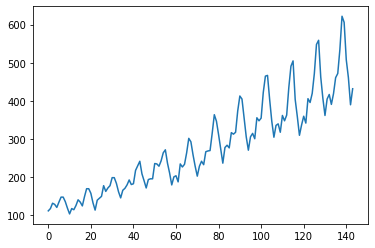

In [ ]:
df["#Passengers"].plot();

### Preparing the data

If we would like to work with a feedforward network, we have to make the data acceptable for a model with a fixed input width (in this case "length", in time).

The most widespread solution for this is to use a *"sliding window"*, where we transform the data so as to create for each time point (considered as $y$) a fixed $x$ - with `window_size`, so we get a dataframe with row number: timesteps minus window size and columns and window size columns as $x$, and a vector with timsteps minus window size length as $y$ value.

|   Step     | Variable | Dimension  |  Variable | Dimension |
|:------------- |:------------| :----- |:-------------|:-----|
|**in**| df|**[data_length, 1]**|window_size| **[scalar]**|
|**out**| x|**[data_length-window_size, window_size]** |y| **[data_length-window_size, 1]** |

In this case we use a sliding window of 10, though 13-14 could also be interesting (if we think back to the PACF analysis of this data). The majority of "signal" is persumed to lie inside the ~10 months range.

We will fit a tiny two layered NN on the data with L1 regularization and Adamm optimizer.


|   Paremeter     | Value | 
|:------------- |:------------| 
|n_hidden_1 | 17 |
| n_hidden_2 | 9 |
| n_input | 10 (window_size) | 
|training_epochs | 100000|
|Optimizer| Adamm|
|learning_rate | 0.01|
|Regularizer| L1|
| l1_lambda |0.00015|


### Let's see the code!

#### Preparing the data

In [ ]:
#Shameless copy of https://stackoverflow.com/questions/27852343/split-python-sequence-time-series-array-into-subsequences-with-overlap 

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

window_size = 10


rolled_data = rolling_window(df["#Passengers"].values, window_size+1)

rolled_train_data, rolled_test_data = train_test_split(rolled_data, test_size=0.1, shuffle=False)

rolled_train_y = rolled_train_data[:,window_size]
rolled_train_x = rolled_train_data[:,:window_size]

rolled_test_y = rolled_test_data[:,window_size]
rolled_test_x = rolled_test_data[:,:window_size]


Let us ensure that the dimensions are ok!

In [ ]:
print(rolled_test_x.shape)
print(rolled_test_y.shape)

(14, 10)
(14,)


In [ ]:
rolled_train_x.shape

(120, 10)

#### Model fit

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

# Parameters
############

hidden_1_size = 17
hidden_2_size = 9

training_epochs = 1000
learning_rate = 0.01
l1_lambda = 0.00015

# Model
#######

inputs = Input(shape=(window_size,))

# Hidden layers

hidden_output_1 = Dense(hidden_1_size, activation='relu', kernel_regularizer=l1(l1_lambda), bias_regularizer=l1(l1_lambda))(inputs)
hidden_output_2 = Dense(hidden_2_size, activation='relu', kernel_regularizer=l1(l1_lambda), bias_regularizer=l1(l1_lambda))(hidden_output_1)

# Prediction layer
predictions = Dense(1, activation='linear')(hidden_output_2)


# Full model
model = Model(inputs=inputs, outputs=predictions)

# Optimizer
####################

optimizer = Adam(lr=learning_rate)
 

# Compilation and fitting 
#########################

model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(x=rolled_train_x, 
                    y=rolled_train_y,
                    validation_data=(rolled_test_x,rolled_test_y),
                    epochs=training_epochs,
                    batch_size=None)

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 63ms/step - loss: 56345.9766 - val_loss: 10982.1729
Epoch 2/1000
4/4 [==============================] - 0s 16ms/step - loss: 9776.7793 - val_loss: 60129.3125
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 13341.7969 - val_loss: 17499.2480
Epoch 4/1000
4/4 [==============================] - 0s 10ms/step - loss: 3690.5869 - val_loss: 11823.6182
Epoch 5/1000
4/4 [==============================] - 0s 11ms/step - loss: 5472.2002 - val_loss: 14456.6797
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 5314.7231 - val_loss: 9759.0811
Epoch 7/1000
4/4 [==============================] - 0s 9ms/step - loss: 3059.1824 - val_loss: 8913.1201
Epoch 8/1000
4/4 [==============================] - 0s 17ms/step - loss: 2786.1040 - val_loss: 11404.6982
Epoch 9/1000
4/4 [==============================] - 0s 11ms/step - loss: 3007.4399 - val_loss: 10196.7910
Epoch 10/1000
4/4 [==============================] - 0s 10ms

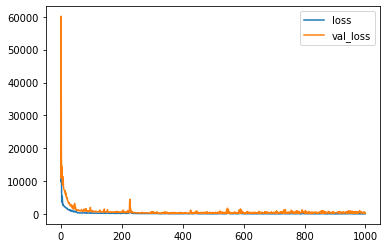

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

History from epoch 20, after initial large losses are no longer dominating the plot:

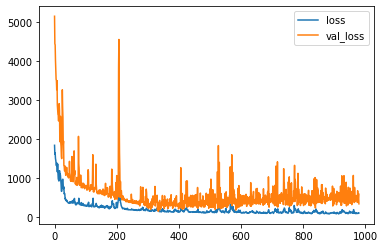

In [ ]:
plt.plot(history.history["loss"][20:], label="loss")
plt.plot(history.history["val_loss"][20:], label="val_loss")
plt.legend()
plt.show()

In [ ]:
print("The minimum for the val_loss is at epoch:",np.array(history.history["val_loss"]).argmin())

The minimum for the val_loss is at epoch: 354


### And let's check the result!

1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


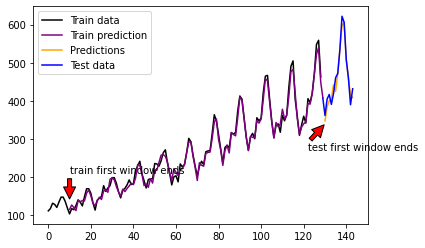

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.1, shuffle=False)

train_predictions = model.predict(rolled_train_x)
test_predictions  = model.predict(rolled_test_x)


out_layer_result_train = pd.Series(train_predictions.flatten())
out_layer_result_test = pd.Series(test_predictions.flatten())

idx = train_data.index[10:]
idx = list(idx)
idx.append(train_data.index[-1]+1)

# Don't ask why this index shit is necessary :-(

out_layer_result_train.index = pd.Index(idx)

out_layer_result_test.index =test_data.index[1:] 


plt.close()
plt.plot(train_data["#Passengers"], label="Train data", color="black")
plt.plot(out_layer_result_train, label="Train prediction", color="purple")
plt.plot(out_layer_result_test, label="Predictions", color="orange")
plt.plot(test_data["#Passengers"], label="Test data", color="blue")

ax = plt.axes()
ax.annotate('train first window ends', xy=(10, 140), xytext=(10, 210),
            arrowprops=dict(facecolor='red', shrink=0.05),)
ax.annotate('test first window ends', xy=(130, 340), xytext=(122, 270),
            arrowprops=dict(facecolor='red', shrink=0.05),)

plt.legend()
plt.show()

On this absurdly small dataset and a ridiculously small NN we reached quite a nice result!

But what if we look into more complex data?

<a id="basicrnn"></a>
# Basic recurrence 


## Recurrent neural networks

### Motivation

Our unquestioned assumption (that even caused some headache in the prior data preparation case) is that **for every neural model the dimensionality of the input has to be fixed**, or only small deviations were allowed (for example in ConvNets we could use some padding, but not too much).

What if my data is **not of uniform length, dynamically sized** - for example because it comes from a (time) series of non-fixed or unknown length?

Or as an alternative formulation of this: From prior knowledge we know, that just as in case of ConvNets for spatial invariance, we have a time series, that implies that has a temporal structure we would like to learn.

As defined before, we interpret our data as time series in the form of $\{x_{t_0}, x_{t_1}, x_{t_2} ... x_{t_n}\}$.

### Structure of recurrent networks - "classic" or "vanilla" RNN

We would like to define a neural network architecture, that in case of an input data point  $x_{t}$ can take into account the effect of prior datapoints without providing those as explicit inputs (as in the feedforward case), but as **(hidden) state**, using the activations of the NN itself.

Till this point we only used the activation for backpropagation, but now we'll use it also for something else.

**Basic idea:**

<a href="https://cdn-images-1.medium.com/max/1400/1*lQ4izz9ZbhKYD8NClZpsmQ.png"><img src="https://drive.google.com/uc?export=view&id=197zCScRaBJypUb0giZzBh_0plHAOzlYJ"></a>

As a **naive solution we could store the activations at $x_{t_-1}$ for all neurons and use a common $\lambda$ "dampening factor"** before adding them to the activations arising at $x_{t}$

$$ f(x_t) = \sigma(w x_t +\lambda a_{t-1} + b)$$ 

This is **not a complete recurrent network**, but something along that direction (it's worth checking whether it works :-)

But if we have a complete neural architecture with weight matrices, why shouldn't we do this in a more clever way?



### Elman network

The first real recurrent network:

[Elman 1990](https://crl.ucsd.edu/~elman/Papers/fsit.pdf): 
Jeffrey L. Elman: Finding structure in time, Cognitive Science 14, p179-p211
<a href="https://cdn-images-1.medium.com/max/1400/1*E6OMkLY8vbPdJ7b5R27FQA.jpeg"><img src="https://drive.google.com/uc?export=view&id=17s60w9qBrwdrazopSAIPHjQ6ttiBgtTn"></a>

**The general notation for recurrent networks:**

**$$h_t=\sigma(Wx_t+Uh_{t-1})$$**

"Legend":

|Symbol| Meaning|
|:---|:---|
|$h_t$| "hidden state" at time $t$ |
|$\sigma$| activation function (typically sigmoid or tanh)|
|$x_t$| input at time $t$ |
|$W$| input to hidden weigth matrix|
|$U$| hidden to hidden weigth matrix|
|$h_{t-1}$| "hidden state" at time $t-1$ |


**In this model we learn two weigth matrices $W$ and $U$.**

Summary  [here](https://medium.com/lingvo-masino/introduction-to-recurrent-neural-network-d77a3fe2c56c).

### Small sidenote: Echo state networks

We take a randomly initialized neural system which may _not_ be ordered in layer structures. Inputs just "perturb" the inner state of these networks, we leave some "settle time" for it to get to a stable state, and use a learned one layer feedforward network to generate predictions (maybe with some "skip" connections from the input).

<a href="http://www.simbrain.net/Documentation/docs/Images/ESNDiagram.png"><img src="https://drive.google.com/uc?export=view&id=1UWsp0ne1yE_xNOHTdLig_KLewYcJekrP" heigth=500 width=500></a>

As a metaphor we can understand that this method has some resemblance to decomposition methods, since it builds up a kind of **"reservoir"** of oscillators (hence the alternative name "reservoir computing"), and the last layer learns only a weighting scheme over the decomposition produced by the oscillators.

Formally the idea was never disproven to work, but the tuning of "settle time", or even more the fact that it was extremely hard to ensure that a diverse and stable set of oscillators are formed during random initialization made it unpopular (though much effort has been invested in solving these issues without a simple and general solution).

The method has some deep connections with [Bolzmann machines](https://en.wikipedia.org/wiki/Boltzmann_machine), but those are out of scope for this training.

Interestingly ESN-s were nearly forgotten, but in 2017 they have found their way into some interesting physics applications modeling chaotic processes like [this](https://arxiv.org/abs/1710.07313).

## Backpropagation through time (BPTT)

Question: How can we teach recurrent neural networks?

Luckily enough, the gradient based methods we have learned are appropriate for this - only with a slight modification.

### "Unrolling"

In order to understand the gradient calculation of recurrent nets we can imagine RNN-s as deep feedforward neural nets "unrolled" in time.

<a href="https://cdn-images-1.medium.com/max/1400/1*icP_8Q-I87k4Nyq0vdSl8A.png"><img src="https://drive.google.com/uc?export=view&id=1BvAx4puhnqLu0rLM6-7ZV2qzSAFeQwO7"></a>

This is all the more useful, since traditionally we implement RNN-s in this "unrolled" way. Nowdays this is not necessarily true, or at least depends on the framework we utilize for training, since some of them solve it with iterations.

In the "unrolled" network **$U$ and $W$ parameters are the same**, so we can understand this as a form of **"weight sharing"**, just as in case of ConvNets, but not through space, but **through time**.

Sensible description [here](https://machinelearningmastery.com/gentle-introduction-backpropagation-time/).

### Problems with this approach

In default case we **calculate through the whole unrolled network for each and every timestep**.

This has quite serious implications:
1. We have to **"see" the whole data at once** (very "un-streaming like")
2. The number of calculated gradients - thus the amount of calculation - **rises exponentially with the length of the dataset**. This easily makes training intractable.

<a id="vanish"></a>
# Exploding and vanishing gradients

(The hard problems)

<a href="http://www.wildml.com/wp-content/uploads/2015/10/rnn-bptt-with-gradients.png"><img src="https://drive.google.com/uc?export=view&id=1IOC6XYlMRWRADH04Wh8iDVG1gXjTdeQA" width=400></a>

But the exploding computational need is just only one part of the problems with RNNs. Since they are extremely deep (in temporal sense) the gradient flow being propagated backward **"vanishes"** most of the time. In practice it results in the effect of signals far away in the past to disappear, as well as for convergence to grind to a halt.

The flipside of this is the effect of **exploding gradients** where the gradient signal gets multiplied while moving backwards in time, getting practically infinite.

These problems in practice are the same as in case of very deep feedforward networks.

A good description can be found [here](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).

### Suggested solutions


#### Careful initialization

Multiple scholars, amongst them one of Hinton's famous collaborators Quoc Le suggested a solution for RNN-s composed of ReLU nodes whereby we initialize the $U$ matrix with a scaled version of the identity matrix.

<a href="https://wikimedia.org/api/rest_v1/media/math/render/svg/e1a4218ab6975ad1809415aa168ab6371b91bafc"><a href="http://drive.google.com/uc?export=view&id=1RPPmiqzRPY6uU5n0FLFjPgLFFaV0zn-C"><img src="https://drive.google.com/uc?export=view&id=1m99E3knMZ4gmvD1UHlZiX-4jruXPVxy-" width=450></a></a>

Details can be found [here](https://arxiv.org/abs/1504.00941).

#### Gradient clipping

As the name implies, it is a procedure whereby we artificially limit, "clip" the gradients during backprop. This is kind of  a"brute force" and semi-effective solution.

<a href="http://drive.google.com/uc?export=view&id=1jK47FvUp7TcUlB2hC4rWDXoxfQNrqhRr"><img src="https://drive.google.com/uc?export=view&id=1MBc8Vx-1Iyeh0TwKxdKiJd37kn9bOyF9" heigth=300 width=300></a>

[Pascanu and Mikolov 2012](https://arxiv.org/pdf/1211.5063.pdf)



#### Teacher forcing

Originally, the concept was to let the hidden state of the network "travel" in time, so that during the learning procedure the network can learn to memorize relevant data. In practice, if we always feed back the prediction of the network to itself, it can "drift away" from target.

Here is where teacher forcing comes in:

"Teacher forcing works by using the **actual or expected output from the training dataset** at the current time step $y_t$ as input in the next time step $X_{t+1}$, **rather than the output generated by the network $\hat{y_t}$**."

<a href="http://cnyah.com/2017/11/01/professor-forcing/non-teacher-teacher-forcing.png"><img src="https://drive.google.com/uc?export=view&id=1zfWZRKEeHRevsa7l3PABGknZIl5TwfOh" height=300></a>

Though in practice this makes convergence easier, but as a tradeoff it also limits the usage of memory capacity. It can work well with unbounded memory capacity models (see later).

For it to work it is necessary for the data to be defined in each step.

It can be considered a move away from the Recursive Multi-step Forecast strategy.

A good walkthrough of teacher forcing can be found [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/).


#### Truncated BPTT

The main idea of this approach is that we should not be so fanatically following signals back into the past, we can do $k1$ steps of forward passes, then do backprop only for the last $k2$ steps back in time, that is:
- We show $k1$ steps for the network
- We unroll the net and calculate $k2$ steps back and aggregate gradients
- We roll up the net and update weigths

**Two parameters:**
- $k1$ decides **how many forward passes happen between backprops** (kind of "batch size") and influences the speed of training (as well as many other factors, _for the newest research in regard to batch size see: [Smith, Kindermans, Ying and Lee 2017](https://arxiv.org/abs/1711.00489)_
- $k2$ influences the **temporal depth of backprop**. If too small, our "window" will not contain all relevant timesteps, if too big, gradients can vanish.

A nice summary again [here](https://machinelearningmastery.com/gentle-introduction-backpropagation-time/).

**Notice, that we could not effectively get rid of those ugly windows!!**

If someone would like to analyse a TensorFlow RNN implementation in detail, it can be done [here](https://www.kdnuggets.com/2017/04/build-recurrent-neural-network-tensorflow.html).

##### Fair warning:

Though **BPTT would be a theoretically more sound solution, practically it is quite unfeasible**. And even the truncated version is implemented sometimes in really strange ways, eg. not letting you control over $k1$ and $k2$ separately, so in practice, much of the potential of LSTM-s may get "sabotaged".

For example you can read about the struggles with Truncated BPTT in Keras [here](https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/). 


#### Anticipated Reweighted Backpropagation through time (ARTBP)

As we might have guessed, the Truncated BPTT approach gives no chance for gradients to flow from the really distant past - outside of the truncation window, so we have to come up with something.

A recent approach is **Anticipated Reweighted Backpropagation through time**

<a href="http://drive.google.com/uc?export=view&id=1AAS4b6-T1Cxl3l_U2DNpDcoUBa4z7jLJ"><img src="https://drive.google.com/uc?export=view&id=1hqCEld-IFPF79PQm_f7jiko0qC0POcor" heigth=900 width=900></a>

"Like truncated BPTT, ARTBP splits the initial sequence into subsequences, and only performs backpropagation through time on subsequences. However, contrary to the latter, it **does not split the sequence evenly**. The length of each subsequence is sampled according to a specific probability distribution. Then the backpropagation equation is modified by introducing a suitable reweighting factor at every step to ensure unbiasedness.

In ARTBP, since random truncations are introduced, gradient computations flow from $t$ to $t'$ with a certain probability, decreasing with $t − t'$. To restore balance, ARTBP rescales gradient flows by their inverse probability. Informally, if a flow has a probability $p$ to occur, multiplication of the flow by $1/p$ restores balance on average."

Full paper [here](https://arxiv.org/pdf/1705.08209.pdf).


<a id="lstm"></a>
# Long short-term memory networks (LSTM)

Get ready to be Schmidhubered! :-)

<a href="https://www.xing.com/img/custom/content/klartext/asset_images/images/000/157/804/x137/image.png?1453288186"><img src="https://drive.google.com/uc?export=view&id=1Ea5cmpxJnHZmZTPNO2DwVr7rfxMAw_wi"></a>

Or more famously [Hochreiter and Schmidhuber 1997](http://www.bioinf.jku.at/publications/older/2604.pdf), in which the heroes are strongly inspired by human short term memory, and would like to create a network which can **store signals for arbitrary, but learned length of time**, enabling it to effectively infinitely "memorize" them.

(The joke term "to be Schmidhubered" comes from the fact that Prof. Schmidhuber has a long time feud with the Hinton group, and he tries to diminish the importance of their findings, claiming that others - amongst them he-  invented key methods before the "deep learning conspiracy". Disturbingly he is sometimes even right. See [this](http://people.idsia.ch/~juergen/deep-learning-conspiracy.html) :-)

## Architecture

**Gold standard explanation: [Colah's Blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)** The personal blog of the researcher Chris Olah.

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png"><img src="https://drive.google.com/uc?export=view&id=1UOtmNeaimbcn3H7CBSeIUfOcjRaubXgY" heigth=300 width=600></a>

### Preliminaries

Cell state "travels" through the process.
<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png"><img src="https://drive.google.com/uc?export=view&id=1IQEqkYz9ThTT1p_9EnO1NJ8xVLQwRsDv"></a>

"Gates" are to be understood as combinations of non-linearities (sigmoid or tanh) and pointwise operations (addition or multiplication).

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-gate.png"><img src="https://drive.google.com/uc?export=view&id=1tUFbRRllulugrK5OBmPGBVidOnqUIMWF"></a>

**Some help: Let us imagine if a vector gets multiplied pointwise with something between 0 and 1, this is equivalent to "deleting" (0) or "leaving intact" (1) some parts of the data.**

### 1. step: What would we like to "forget"?

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png"><img src="https://drive.google.com/uc?export=view&id=1J1_LbATvWLASY4OJsJ95txk9SCWjeYHR"></a>

### 2. step: What and where would we like to store?

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png"><img src="https://drive.google.com/uc?export=view&id=1ZpIjdziGKlIacF4M7GpO9GRvxVPxGK7j"></a>

### 3. step: Update the cell state!

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png"><img src="https://drive.google.com/uc?export=view&id=1jjM4MSIqgqNIz69K4jQUZtVjzTskezF_"></a>

### 4. step: Choose and produce the output!

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png"><img src="https://drive.google.com/uc?export=view&id=1_gjSEe6CW1yc_QTCPhGEqM5Bst3D0SId"></a>

#### Alternative explanation [here](http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/)

This may be worth reading through, since it shows in detail each vector's dimensionality.

#### Animated illustration

<a href="https://miro.medium.com/max/1425/1*GjehOa513_BgpDDP6Vkw2Q.gif"><img src="https://drive.google.com/uc?export=view&id=1w42nZqQKTl8Mqsc0PTTOk0GAyvNizixi" width=75%></a>
<a href="https://miro.medium.com/max/1425/1*TTmYy7Sy8uUXxUXfzmoKbA.gif"><img src="https://drive.google.com/uc?export=view&id=1pPO0OsgGRjJsjTCDSTJanmZMc_k7zKqn" width=75%></a>
<a href="https://miro.medium.com/max/1425/1*S0rXIeO_VoUVOyrYHckUWg.gif"><img src="https://drive.google.com/uc?export=view&id=1T5USGg1LHTFkWQcTVulrcfmH3GjbMWcm" width=75%></a>
<a href="https://miro.medium.com/max/1425/1*VOXRGhOShoWWks6ouoDN3Q.gif"><img src="https://drive.google.com/uc?export=view&id=1hsXLmHrT6pKG1iVr9Ccav4HrU7woBFuW" width=75%></a>

[source](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

## Properties

- "Unreasonably effective" Andrej Karpathy's famous blogpost [here](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)


- Not just effective, but "Turing complete"

Based on this Yann LeCun (the pioneer of "backpropaganda" and big name in ConvNets) talks not just about "deep learning", but "differentiable computing". LSTM blocks combined - amongst themselves or ConvNets, seq2seq models or memory networks (see later) are making this position more and more plausible.)

- **Its inner state can effectively summarize long sequences of signals.**

We can consider the **final hidden state of activation of an LSTM at the end of a sequence** the dense vector representation **summarizing the totality of singals for that sequence**. This is a _huge_ advantage for us (for sequence classification or for more advanced operations - see seq2seq).

- **Does not formally solve exploding gradients**, but for that we have brute force **gradient clipping**.

## Variants

### "Peephole connections"
[Recurrent nets that time and count](http://ieeexplore.ieee.org/document/861302/)

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-peepholes.png"><img src="https://drive.google.com/uc?export=view&id=166ktVxHa3c2b7hGeuI6MYFTe3Fv5cuwT"></a>

The idea is really similar to "highway" or "skip" connections in case of ConvNets, essentially easing the gradient flow with direct links, as well as adding information for the local decisions of the gates.

Details again at the [blog of Chris Olah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Gated recurrent unit

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png"><img src="https://drive.google.com/uc?export=view&id=1a6tOZ35ZgeJtxMluZ9tSAJomrq_Cmfen"></a>

[Cho et al. 2014](https://arxiv.org/abs/1406.1078)

+ combines the forget gate and input gate into an "update gate"
+ merges the cell state and hidden state
+ => a little bit faster than LSTM

## LSTM as layers

+ An LSTM - how ever strange that may sound - can be considered to be a complete layer. The most important parameter of it is the "number of (memory) units", which is the length of the hidden state vector, thus, the memory capacity. **Warning: this does not have any relationship to input size, thus can be considered a freely chosen parameter.**
+ It is quite widespread to use multiple LSTM layers ("stacked LSTMs") -- as in the case of ConvNets the hope is, that the layers learn a hierarchy of abstract representations:

<a href="http://wenchenli.github.io/assets/img/GNMT_residual.png"><img src="https://drive.google.com/uc?export=view&id=1cbf6VvnPTkQwJZjv2jZfpC2-w3zxLSbq" width=60%></a>

(on the right side a network is shown with skip/residual connections!)

In this case it makes sense, that we do not only get on top of the LSTM a final prediction $h$ (or even prediction + inner state vector $c$) for a sequence, but **we ask it to output the whole sequence of predictions**, so that the next layer can also operate on full sequences. Please bear this in mind during implementation, since this can be a common source of failure.  

Also worth noting, that the practicality of multi layer LSTMs have been recently questioned by some researchers, since they aruge, that one layer of LSTM can learn nearly everything a multi layer one can in practice - given the right "treatment". See more [here]( https://arxiv.org/abs/1909.00021).

## Basic LSTM example

Let us go through a **basic** LSTM  example based on a [publicly available property manintenance dataset](# https://combed.github.io/).

**This is _not_ a full datascience project, only the demonstration of some data preparation and training concepts!**

In [ ]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/Power.csv?inline=false -O Power.csv

--2022-11-10 16:07:55--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/master/Power.csv?inline=false
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3128452 (3.0M) [application/octet-stream]
Saving to: ‘Power.csv’

Power.csv           100%[===================>]   2.98M  --.-KB/s    in 0.07s   

2022-11-10 16:07:56 (39.9 MB/s) - ‘Power.csv’ saved [3128452/3128452]



In [ ]:
# Source: Dataset / Academic / Power sockets / 3

df = pd.read_csv("Power.csv", header=None)
df.columns = ["Timestamp","Power"]
df.head()

,Timestamp,Power
0,1.401595e+12,58.694874
1,1.401595e+12,58.465698
2,1.401595e+12,58.090099
3,1.401595e+12,58.260864
4,1.401595e+12,58.002567


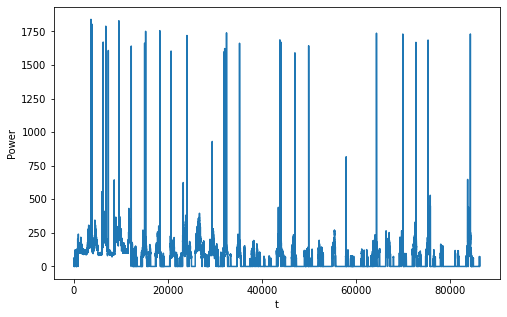

In [ ]:
df["Power"].plot(figsize=(8,5), ylabel="Power", xlabel="t")
plt.show()

In [ ]:
print("Shape: ",df.shape)

Shape:  (86200, 2)


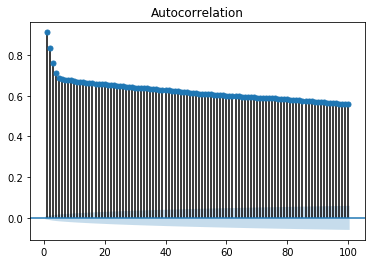

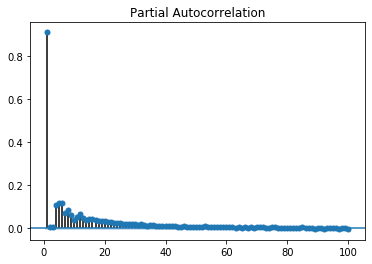

---


In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(df.Power, lags=100, zero=False)
plot_pacf(df.Power, lags=100, zero=False)
plt.show()
print("---")

In [ ]:
!pip install seglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 8.7 MB/s 


In [ ]:
VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=100
FORECAST_DISTANCE=1

### Doing train-valid-test split.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_else = train_test_split(df.Power, test_size=VALID_AND_TEST_SIZE*2, shuffle=False)
X_valid, X_test= train_test_split(X_else, test_size=0.5, shuffle=False)

### Rolling window

Using the wonderful [seglearn](https://dmbee.github.io/seglearn/) library to generate rolling windows from the training data.

In [ ]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values.flatten()],[X_train.values.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values.flatten()],[X_valid.values.flatten()])
X_test_rolled, y_test_rolled,_=segmenter.fit_transform([X_test.values.flatten()],[X_test.values.flatten()])

In [ ]:
X_train_rolled.shape, y_train_rolled.shape

((68860, 100), (68860,))

In [ ]:
np.testing.assert_equal(X_train[:TIME_WINDOW].values,X_train_rolled[0])

In [ ]:
np.testing.assert_equal(X_train[TIME_WINDOW-1+FORECAST_DISTANCE],y_train_rolled[0])

In [ ]:
# Warning, Keras needs a 1D matrix, not a vector, so one must do:

X_train_rolled = X_train_rolled[:,:, np.newaxis]
X_valid_rolled = X_valid_rolled[:,:, np.newaxis]
X_test_rolled = X_test_rolled[:,:, np.newaxis]

## SHAPE: (samples, timesteps, variables)
print(X_train_rolled.shape)

(68860, 100, 1)


###### First: LSTM layer in keras

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as be
import tensorflow as tf

## we use 10 samples
## and 4 units (hidden state is 4-long for each time step)

tf.random.set_seed(42)
be.clear_session()
input_layer = X_train_rolled[:10]

whole_seq_output, final_memory_state, final_carry_state =  LSTM(4, return_sequences=True, return_state=True)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output2 =  LSTM(4, return_sequences=True, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
out_last =  LSTM(4, return_sequences=False, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output3, final_memory_state3, final_carry_state3 =  LSTM(4, return_sequences=False, return_state=True)(input_layer)


print("return_sequences=True, return_state=True")
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

print()
print("return_sequences=True, return_state=False")
print(whole_seq_output2.shape)

print()
print("return_sequences=False, return_state=False")
print(out_last.shape)

print()
print("return_sequences=False, return_state=True")
print(whole_seq_output3.shape)
print(final_memory_state3.shape)
print(final_carry_state3.shape)



return_sequences=True, return_state=True
(10, 100, 4)
(10, 4)
(10, 4)

return_sequences=True, return_state=False
(10, 100, 4)

return_sequences=False, return_state=False
(10, 4)

return_sequences=False, return_state=True
(10, 4)
(10, 4)
(10, 4)


In [ ]:
print("For first sample...\n")
print("\treturn_sequences=True, return_state=True")
print("\tlast two time step hidden state output:", np.array(whole_seq_output[0][-2:]))
print("\tfinal hidden state (=output):", np.array(final_memory_state[0]))
print("\tfinal cell state:", np.array(final_carry_state[0]))

print()
print("\treturn_sequences=True, return_state=False")
print("\tlast two time step hidden state output:", np.array(whole_seq_output2[0][-2:]))

print()
print("\treturn_sequences=False, return_state=False")
print("\tfinal hidden state (=output):", np.array(out_last[0]))

print()
print("\treturn_sequences=False, return_state=True")
print("\thidden state:", np.array(whole_seq_output3[0]))
print("\tfinal hidden state (=output):", np.array(final_memory_state3[0]))
print("\tfinal cell state:", np.array(final_carry_state3[0]))



For first sample...

	return_sequences=True, return_state=True
	last two time step hidden state output: [[-1.0911820e-11 -7.0297241e-01  6.1320490e-01  9.9788213e-01]
 [-9.1309703e-12 -7.0937777e-01  6.1334676e-01  9.9833649e-01]]
	final hidden state (=output): [-9.1309703e-12 -7.0937777e-01  6.1334676e-01  9.9833649e-01]
	final cell state: [-0.99999166 -0.9432125   0.72170997  3.5455837 ]

	return_sequences=True, return_state=False
	last two time step hidden state output: [[-1.0911820e-11 -7.0297241e-01  6.1320490e-01  9.9788213e-01]
 [-9.1309703e-12 -7.0937777e-01  6.1334676e-01  9.9833649e-01]]

	return_sequences=False, return_state=False
	final hidden state (=output): [-9.1309703e-12 -7.0937777e-01  6.1334676e-01  9.9833649e-01]

	return_sequences=False, return_state=True
	hidden state: [-9.1309703e-12 -7.0937777e-01  6.1334676e-01  9.9833649e-01]
	final hidden state (=output): [-9.1309703e-12 -7.0937777e-01  6.1334676e-01  9.9833649e-01]
	final cell state: [-0.99999166 -0.9432125 

###### Model definition

In [ ]:
#---- Hyperparams and settings ----

EPOCHS = 30
BATCH_SIZE = 200
LEARNING_RATE = 0.1
LSTM_CELL_SIZE = 300

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

column_count=1

be.clear_session()

input_layer = Input(shape=(TIME_WINDOW,column_count))

lstm_layer = LSTM(LSTM_CELL_SIZE)(input_layer)

dense_layer = Dense(1)(lstm_layer)

model = Model(inputs=input_layer, outputs=dense_layer)

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(x=X_train_rolled,y=y_train_rolled, batch_size=BATCH_SIZE, validation_data=(X_valid_rolled,y_valid_rolled), epochs=EPOCHS, verbose=1, shuffle=False)



Train on 68860 samples, validate on 8520 samples
Epoch 1/30
68860/68860 [==============================] - 48s 691us/sample - loss: 5884.7970 - val_loss: 6182.0641
Epoch 2/30
68860/68860 [==============================] - 39s 570us/sample - loss: 4643.1830 - val_loss: 5918.2724
Epoch 3/30
68860/68860 [==============================] - 39s 562us/sample - loss: 4318.2682 - val_loss: 5540.1538
Epoch 4/30
68860/68860 [==============================] - 39s 570us/sample - loss: 3836.3652 - val_loss: 5271.9356
Epoch 5/30
68860/68860 [==============================] - 39s 568us/sample - loss: 3569.0519 - val_loss: 5015.1448
Epoch 6/30
68860/68860 [==============================] - 39s 564us/sample - loss: 3232.4642 - val_loss: 4886.2774
Epoch 7/30
68860/68860 [==============================] - 39s 563us/sample - loss: 3105.7792 - val_loss: 4721.2178
Epoch 8/30
68860/68860 [==============================] - 39s 571us/sample - loss: 3018.6925 - val_loss: 4697.4197
Epoch 9/30
68860/68860 [=======

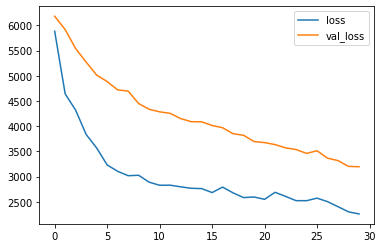

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test_rolled).flatten()

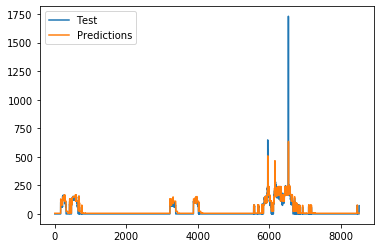

In [ ]:
plt.close()
plt.plot(list(X_test[100:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()

## How is this model to be improved?

In many ways this model is too basic, needs heavy improvement.

1. Let it run further
2. Does not use regularization at all, Dropout should be added. The question is where to put it in RNNs, for this see [here](http://dx.doi.org/10.1109/ICDAR.2015.7333848) and [here](https://arxiv.org/abs/1512.05287)
3. Should use some data normalization, details can be found [here](https://machinelearningmastery.com/normalize-standardize-time-series-data-python/)
4. Usage of squared loss is also questionable
5. It does not solve the transfer of inner **states between minibatches** and on epoch begin (called "statefulness" and "warmup" respectively). Tips for **Warmup** [here](https://arxiv.org/pdf/1710.03222.pdf), for statefullness [here](https://stackoverflow.com/questions/38241410/tensorflow-remember-lstm-state-for-next-batch-stateful-lstm?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)
6. Hyperparameters could be optimized manually or with search techniques
7. Multiple LSTM layers can be stacked upon each-other

As said, a really basic model...

# Probabilistic extension

Though RNNs, especially LSTM-s have remarkable properties and capacity for prediction, in practice, their application in real life times series data has been limited mainly because in their default form they are __incapable of producing probabilistic estimates__ such as confidence intervals around the prediction.

In 2017 Amazon - motivated by it's extensive challenges in predicting customer orders - set out to refine the default LSTM implementation and to add probabilistic capabilities. The resulting [DeepAR](https://arxiv.org/abs/1704.04110) model can be considered as a general extension to RNN-s.

<img src="http://drive.google.com/uc?export=view&id=1DKvFQjSKyVVc0yAq9wW4ZGBnyXNVMbnH" width=75%>

In this model the RNN layers are basically outputting parameters for a previously assumed noise distribution, so the final predictions are generated by the sampling of this said distribution. In case of learning, this output is being used to do the parameter updates, in case of prediction, multiple "monte carlo" samples are drawn from the distribution to generate the confidence estimates.


For a nice short intro see [here](https://www.youtube.com/watch?v=zQvHESgqFcU).

As a result, one can not just have pretty accurate point estimations, but reliable confidence bounds for a time series.

<img src="http://drive.google.com/uc?export=view&id=1rTzSHE5PnwToJfyovVaSWGpp2SUcbQx0">

<a id="necessary"></a>

# Are LSTM-s really necessary?

LSTMs, when combined with dropout and other techniques became **hugely successful** and were considered the workhorse of NLP and time series applications, as well as sequence to sequence problems, moreover they serve as basis for all memory network architectures. They were and are still dominant in these fields.

None the less as of 2017-8, multiple findings emerged that question the necessity for LSTMs in many fields. The leading field in this regard was neural machine translation, where Facebook Research developed it's [ConvNet based  machine translation](https://code.fb.com/ml-applications/a-novel-approach-to-neural-machine-translation/), as well as Google publishing the [transformer architecture](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html). Both approaches were motivated by the fact that LSTM computation is not easily parallelized, but ConvNets and transformers are, so training can be scaled up rapidly.

Based on these networks multiple analyses tried to justify the usage of LSTMs and found, that though they have in theory infinite memory ability, in practice, a limited memory is good enough, which can be modeled by ConvNets, especially 1D and dilated convolutions.

For more information see [here](https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0) [here](http://www.offconvex.org/2018/07/27/approximating-recurrent/) [here](http://blog.aylien.com/acl-2018-highlights-understanding-representations-and-evaluation-in-more-challenging-settings/) [here](https://arxiv.org/abs/1803.01271)

(Interesting snippets or remarks from the above sources:
“LSTMs work in practice, but can they work in theory?”
" “According to Chomsky, sequential recency is not the right bias for learning human language. RNNs thus don’t seem to have the right bias for modeling language, which in practice can lead to statistical inefficiency and poor generalization behaviour.")


Alternative approaches as ["recursive neural networks"](https://en.wikipedia.org/wiki/Recursive_neural_network) and ["recurrent neural network grammars"](https://arxiv.org/abs/1602.07776) also exist, but not that widespread.




## Convolutions for time series

We use convolution operators, but only in one dimension over the data.

<a href="http://mblogthumb2.phinf.naver.net/MjAxNjEyMTBfMjMx/MDAxNDgxMjk1ODk2NDAz.kn9JN93v9X2Xn9vJloqupV5c5GB09YNYwPrvDB8yKU8g.Hh1wT30ySu0JFWNqj2qoSTiX-pRnrjH2VWhMI2EAo30g.PNG.atelierjpro/%EC%8A%AC%EB%9D%BC%EC%9D%B4%EB%93%9C2.PNG?type=w2"><img src="https://drive.google.com/uc?export=view&id=1VlPqHI2s8NyI2kaaHIrjGwtd4FClAbVZ" width=600 heigth=600></a>

Look, look, we have reinvented sliding windows! :-(

<a href="https://qph.fs.quoracdn.net/main-qimg-523434af0d21bb0b59454aa9563cc90b-c"><img src="https://drive.google.com/uc?export=view&id=1uuL9sC25DnbdL-bD-DmqNp1tFX6-xVaX" width=600 heigth=600></a>

Though if we [calculate the receptive fileds](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807) of these models, with enough depth they can be formidable!

### Dilated convolutions

Dilated convolutions are used to radically increase the total receptive field of a network.

<a href="http://sergeiturukin.com/assets/2017-02-23-155956_803x294_scrot.png"><img src="https://drive.google.com/uc?export=view&id=1x12ed5qvn3Ls-glPeYBArzC6w3Wb2Br9" width=600 heigth=600></a>


<a href="https://mlblr.com/images/dilated.gif"><img src="https://drive.google.com/uc?export=view&id=1meYEWWcBbrvJy21PBTSUSUd0oTjAveJh" width=400 heigth=400></a>

Original paper [here](https://arxiv.org/abs/1511.07122)

[Wavenet](http://sergeiturukin.com/2017/03/02/wavenet.html) and other successful models (especially in voice recognition) use this approach effectively.

### Convolutional filters and wavelets

It is also interesting to note, that convolutions over a timeseries can be understood as generalizations of "wavelet / shapelet" approaches, with the added benefit, that here the definition of "mother wavelet" is not that problematic.

<a href="https://www.researchgate.net/profile/Zoltan_German-Sallo/publication/266056525/figure/fig1/AS:295770143117318@1447528505764/The-Continuous-Wavelet-Transform-as-a-convolution-between-data-signal-and-scaled-and.png"><img src="https://drive.google.com/uc?export=view&id=1pxADzQu_mXziCGTy4BIyHGVSntyLkuAV" width=45%></a>



# Neural models for time series similarity

Some really successful neural models eg. for time series similarity (like [this](https://arxiv.org/pdf/1812.08306.pdf)) also capitalize on the flexibility of neural models for pattern recognition in timeseries, thus forming effective competition to the tried and true Fourier spectral methods and [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping).

<a href="http://drive.google.com/uc?export=view&id=1WrrsD273HFeWQkKnTDGnv-PxP4cWU6Ph"><img src="https://drive.google.com/uc?export=view&id=1945TUDRilACpGXhgGWHXO4kh9JWghL7k" widht=75%></a>